# GENERATIVE ADVERSARIAL NETWORKS

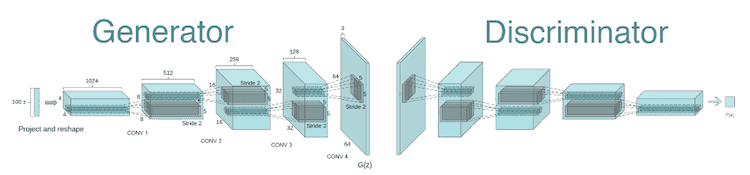

Generative Adversarial Networks,for short GANs are an unsupervised (some sources call semi-supervised) architecture that provides shytetic data like a photo that looks like a human face but human does not exist. Like all other machine learning models it learns from data. We will dive into 3 main concepts of GANs; discriminator, generator and loss function.

## Discriminator

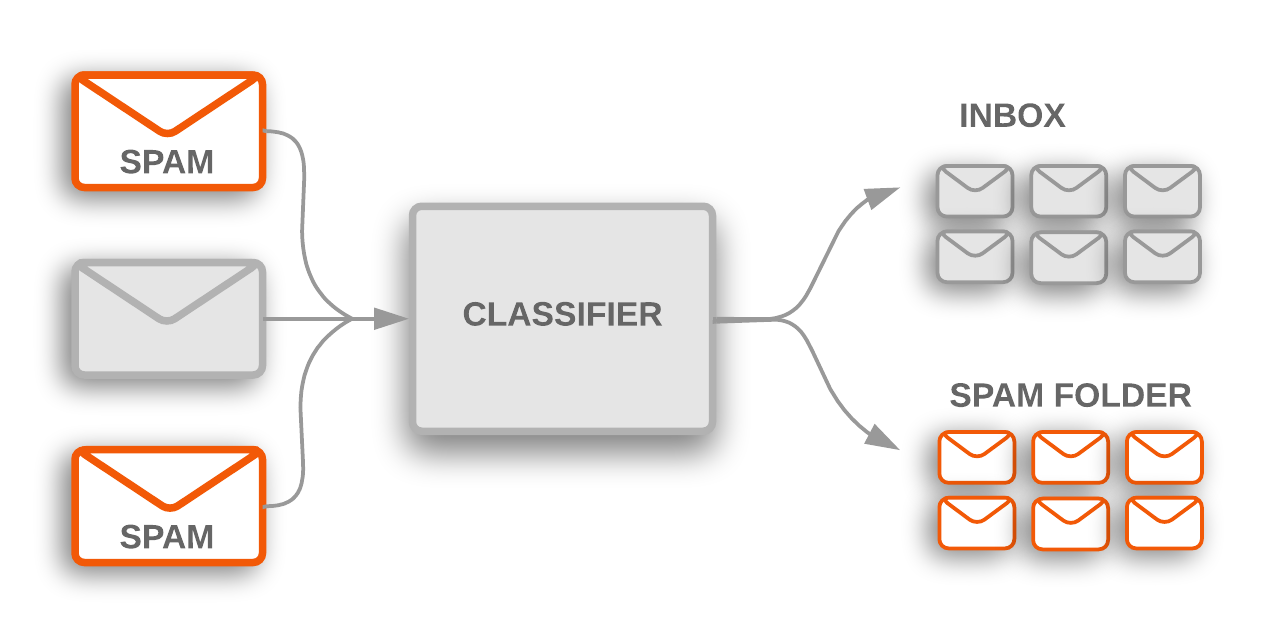

The biggest area of machine learning is classification. There are many traditional machine learning algorithm for classification like KNN, SVM, Logistic Regression etc. and also deep learning models work for that. Actually, GANs are deep learning architectures, that consist of two different models, and one of them is called the discriminator that classifies inputs as real or fake. The discriminator model that learns to determine whether a sample is from the model distribution (generator, we will be talking about it next part) or the data distribution.

## Generator 

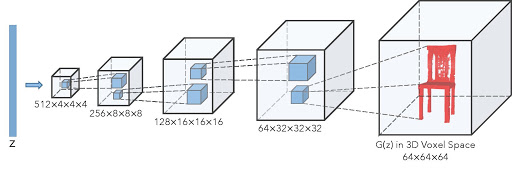

The generator tries to catch the distrubiton of dataset to provide shytetic data. It takes random vector called as noise vector, mostly gaussian distrubiton,mean equals zero and standart deviation equals one. Then model the generator upsamples the vector to wanted shape of the data will be provided.

## Loss Function 

<font size="5">
$$\min_G \max_D V(D,G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(x)}[\log D(\mathbf{x})] + \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z)))]$$
</font>

Most important concepts of machine learning is the loss function we want to minimize. Neural network architectures provide a function that maps our data ($x$) to the result ($y$).First, vector $X$ have weights that randomly initilized, after epochs of forward and backward propagation weights are getting right values to minimize loss function. Why loss function is so important ? To reduce loss value model need to know what is wrong with parameters. We will be using Binary Cross Entropy Loss for this architecture. BCE Loss represents the error of discriminator on real data and generator on noise vector at the same time. First component of formula $\log D(x)$, discriminator works on real daha, that means discriminator must predict 1 (label of real = 1, label of fake = 0). $\log D(1) = 0$, error equals 0. Second component of formula $\log (1-D(G(z)))$, generator works on noise vector then discriminator tries to predict it is real or fake. If the output of generator classifies by discriminator as real, that means generator works well. For short, the model tries to maximize $D(x)$ and minimize $D(G(z))$.



## All in one with counterfeiter - Police Metaphor

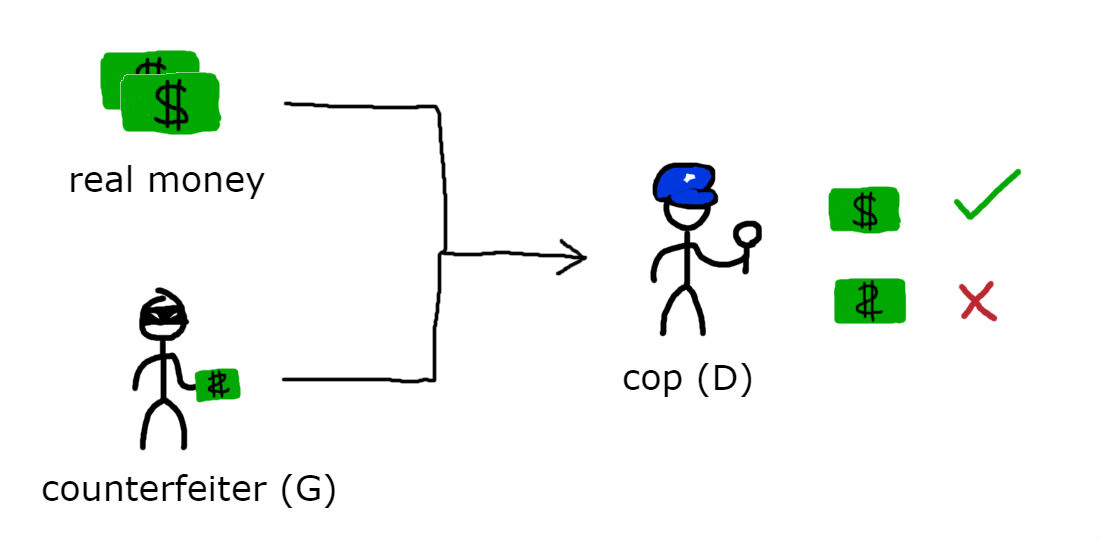

* Counterfeiter : Generator
* Police : Discriminator 

Counterfeiter tries to produce fake money and police tries to find out if it is real or fake. At the beginning counterfeiter produces money but police eaisly detects it is fake. After a few tries, counterfeiter is able to generate more realistic money but at the same the police can better distinguish between real money and fake money. That is Generative Adversarial Networks.

In [36]:
%matplotlib inline
import numpy as np
import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import pickle as pkl


In [37]:
#Numworkers are the number of batches we will move to the GPU while
#model propagates forward and backward.
num_workers = 1 #For my GPU, 1 is the fastest.
batch_size = 64

#At the related paper Goodfellow's GANs, there is no transform for dataset.
transform = transforms.ToTensor()

#Downlaod the data
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers,shuffle = True)

In [38]:
device = torch.device("cuda")

In [39]:
torch.cuda.is_available()
print(torch.__version__)

1.7.0


In [49]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # Defining hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*2)#input size = 28*28
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc3 = nn.Linear(hidden_dim*4, hidden_dim)
        
        # Output layer, it will return a probability,
        #so output_size must be 1
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer. It is important about stabilization of model. 
        self.dropout = nn.Dropout(0.35)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Flatten
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, slope)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)
        #x = self.sigmoid(x)

        return x

In [50]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # Defining hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim)# Input size equals noise vector size.
        #We will define it as 100 like Goodfellow
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # Output size of generator must be equal to input size of discriminator.
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer. It is important to prevent mode collapse
        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, slope)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # At the paper, tanh has been used.
        x = torch.tanh(self.fc4(x))

        return x

In [51]:
# Discriminator hyperparams

input_size = 784 # 28*28

d_output_size = 1 # Probability, so it is 1

d_hidden_size = 32 # To control the number of perceptron of hidden layers eaisly

# Generator hyperparams


z_size = 100 # Shape of noise vektor

g_output_size = 784 # It must be equal to input size of discriminator
g_hidden_size = 125 # To control the number of perceptron of hidden layers eaisly

In [52]:
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device)


print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (sigmoid): Sigmoid()
)
Generator(
  (fc1): Linear(in_features=100, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


In [53]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # In order to prevent the discriminitor from being too developed and the generator from lagging behind
        labels = (torch.ones(batch_size)*0.9).cuda()
    else:
        labels = torch.ones(batch_size).cuda() # real labels = 1
        
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).cuda() # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [54]:
lr = 0.002 #According to related paper.

#2 optimizer for 2 different models
d_optimizer = optim.SGD(D.parameters(), lr)
g_optimizer = optim.SGD(G.parameters(), lr)

In [59]:
# number of epochs
num_epochs = 250

samples = [] # To storage generated data
losses = [] # To storage loss values

print_every = 5000 #


sample_size=16 #number of images that will be generated
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size)) # random noise
fixed_z = (torch.from_numpy(fixed_z).float()).cuda()

D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # Rescaling yapmamız gerek
        real_images = (real_images*2 - 1).cuda() #[0,1) to [-1, 1)
        
       
        #  TRAINING model DISCRIMINATOR
        
        
        d_optimizer.zero_grad()
        
        # 1 : Train with real images

        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2 : Train with fake images
        
        # Generating fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().cuda()
        fake_images = G(z)
        
            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Sum loss and backward prop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
       
        # TRAINING model GENERATOR
        
        g_optimizer.zero_grad()
        
        
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().cuda()
        fake_images = G(z)
        
        
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # backprop
        g_loss.backward()
        g_optimizer.step()

        # Print Loss
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    #Save losses
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generate and save images
    G.eval() # Eval Mode
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Train mode


# Save images to local
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  250] | d_loss: 1.0344 | g_loss: 1.4126
Epoch [    2/  250] | d_loss: 0.9832 | g_loss: 1.6313
Epoch [    3/  250] | d_loss: 1.1272 | g_loss: 1.3497
Epoch [    4/  250] | d_loss: 0.9522 | g_loss: 1.4205
Epoch [    5/  250] | d_loss: 0.9462 | g_loss: 1.7137
Epoch [    6/  250] | d_loss: 1.0970 | g_loss: 1.4590
Epoch [    7/  250] | d_loss: 1.0195 | g_loss: 1.4484
Epoch [    8/  250] | d_loss: 1.0475 | g_loss: 1.4589
Epoch [    9/  250] | d_loss: 1.1311 | g_loss: 1.2154
Epoch [   10/  250] | d_loss: 0.9541 | g_loss: 1.6910
Epoch [   11/  250] | d_loss: 1.1156 | g_loss: 1.3769
Epoch [   12/  250] | d_loss: 1.0619 | g_loss: 1.5226
Epoch [   13/  250] | d_loss: 0.9615 | g_loss: 1.5287
Epoch [   14/  250] | d_loss: 1.0003 | g_loss: 1.5019
Epoch [   15/  250] | d_loss: 0.9346 | g_loss: 1.4337
Epoch [   16/  250] | d_loss: 1.0692 | g_loss: 1.4469
Epoch [   17/  250] | d_loss: 0.9590 | g_loss: 1.4682
Epoch [   18/  250] | d_loss: 0.9778 | g_loss: 1.5376
Epoch [   19/  250] | d_loss

Epoch [  153/  250] | d_loss: 0.9588 | g_loss: 2.0003
Epoch [  154/  250] | d_loss: 0.9475 | g_loss: 1.9196
Epoch [  155/  250] | d_loss: 1.0507 | g_loss: 2.0751
Epoch [  156/  250] | d_loss: 0.9799 | g_loss: 2.0401
Epoch [  157/  250] | d_loss: 0.9213 | g_loss: 1.5929
Epoch [  158/  250] | d_loss: 0.8968 | g_loss: 1.8734
Epoch [  159/  250] | d_loss: 0.8250 | g_loss: 1.9624
Epoch [  160/  250] | d_loss: 0.9008 | g_loss: 2.0406
Epoch [  161/  250] | d_loss: 0.8625 | g_loss: 1.7351
Epoch [  162/  250] | d_loss: 1.0161 | g_loss: 1.9467
Epoch [  163/  250] | d_loss: 0.9154 | g_loss: 1.7544
Epoch [  164/  250] | d_loss: 0.9823 | g_loss: 1.8428
Epoch [  165/  250] | d_loss: 0.9425 | g_loss: 1.4934
Epoch [  166/  250] | d_loss: 0.8285 | g_loss: 1.7783
Epoch [  167/  250] | d_loss: 1.0070 | g_loss: 1.8877
Epoch [  168/  250] | d_loss: 0.8475 | g_loss: 2.0829
Epoch [  169/  250] | d_loss: 0.8098 | g_loss: 1.6376
Epoch [  170/  250] | d_loss: 0.9442 | g_loss: 1.7929
Epoch [  171/  250] | d_loss

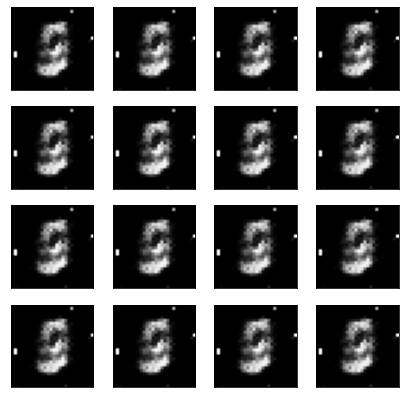

In [60]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)).cpu(), cmap='Greys_r')

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)